# Tutorial: Reduced Order Model with Graph Neural Networks

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathLab/PINA/blob/master/tutorials/tutorial22/tutorial.ipynb)


> ##### ⚠️ ***Before starting:***
> We assume you are already familiar with the concepts covered in the [Data Structure for SciML](https://mathlab.github.io/PINA/tutorial19/tutorial.html) tutorial. If not, we strongly recommend reviewing them before exploring this advanced topic.

In this tutorial, we will demonstrate a typical use case of **PINA** for Reduced Order Modelling using Graph Convolutional Neural Network. The tutorial is largely inspired by the paper [A graph convolutional autoencoder approach to model order reduction for parametrized PDEs](https://www.sciencedirect.com/science/article/pii/S0021999124000111).

Let's start by importing the useful modules:

In [ ]:
## routine needed to run the notebook on Google Colab
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install "pina-mathlab[tutorial]"
    !wget "https://github.com/mathLab/PINA/raw/refs/heads/master/tutorials/tutorial22/holed_poisson.pt" -O "holed_poisson.pt"

import torch
from torch import nn
from torch_geometric.nn import GMMConv
from torch_geometric.data import Data, Batch # alternatively, from pina.graph import Graph, LabelBatch
from torch_geometric.utils import to_dense_batch

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

from pina import Trainer
from pina.model import FeedForward
from pina.optim import TorchOptimizer
from pina.solver import ReducedOrderModelSolver
from pina.problem.zoo import SupervisedProblem

## Data Generation

In this tutorial, we will focus on solving the parametric **Poisson** equation, a linear PDE. The equation is given by:

$$
\begin{cases}
-\frac{1}{10}\Delta u = 1, &\Omega(\boldsymbol{\mu}),\\
u = 0, &\partial \Omega(\boldsymbol{\mu}).
\end{cases}
$$

In this equation, $\Omega(\boldsymbol{\mu}) = [0, 1]\times[0,1] \setminus [\mu_1, \mu_2]\times[\mu_1+0.3, \mu_2+0.3]$ represents the spatial domain characterized by a parametrized hole defined via $\boldsymbol{\mu} = (\mu_1, \mu_2) \in \mathbb{P} = [0.1, 0.6]\times[0.1, 0.6]$. Thus, the geometrical parameters define the left bottom corner of a square obstacle of dimension $0.3$. The problem is coupled with homogenous Dirichlet conditions on both internal and external boundaries. In this setting, $u(\mathbf{x}, \boldsymbol{\mu})\in \mathbb{R}$ is the value of the function $u$ at each point in space for a specific parameter $\boldsymbol{\mu}$. 

We have already generated data for different parameters. The dataset is obtained via $\mathbb{P}^1$ FE method, and an equispaced sampling with 11 points in each direction of the parametric space. 

The goal is to build a Reduced Order Model that given a new parameter $\boldsymbol{\mu}^*$, is able to get the solution $u$ *for any discretization* $\mathbf{x}$. To this end, we will train a Graph Convolutional Autoencoder Reduced Order Model (GCA-ROM), as presented in [A graph convolutional autoencoder approach to model order reduction for parametrized PDEs](https://www.sciencedirect.com/science/article/pii/S0021999124000111). We will cover the architecture details later, but for now, let’s start by importing the data.

**Note:**
The numerical integration is obtained using a finite element method with the [RBniCS library](https://www.rbnicsproject.org/).

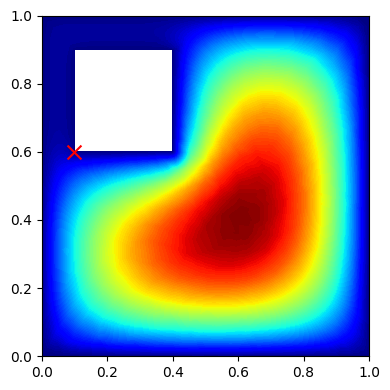

In [21]:
# === load the data ===
# x, y -> spatial discretization
# edge_index, triang -> connectivity matrix, triangulation
# u, params -> solution field, parameters

data = torch.load("holed_poisson.pt")
x = data['x']
y = data['y']
edge_index = data['edge_index']
u = data['u']
triang = data['triang']
params = data['mu']

# simple plot
plt.figure(figsize=(4, 4))
plt.tricontourf(x[:, 10], y[:, 10], triang, u[:, 10], 100, cmap='jet')
plt.scatter(params[10, 0], params[10, 1], c='r', marker="x", s=100)
plt.tight_layout()
plt.show()

## Graph-Based Reduced Order Modeling

In this problem, the geometry of the spatial domain is **unstructured**, meaning that classical grid-based methods (e.g., CNNs) are not well suited. Instead, we represent the mesh as a **graph**, where nodes correspond to spatial degrees of freedom and edges represent connectivity. This makes **Graph Neural Networks (GNNs)**, and in particular **Graph Convolutional Networks (GCNs)**, a natural choice to process the data.

<p align="center">
    <img src="http://raw.githubusercontent.com/mathLab/PINA/master/tutorials/static/gca_off_on_3_pina.png" alt="GCA-ROM" width="800"/>
</p>

To reduce computational complexity while preserving accuracy, we employ a **Reduced Order Modeling (ROM)** strategy (see picture above). The idea is to map high-dimensional simulation data $u(\mathbf{x}, \boldsymbol{\mu})$ to a compact **latent space** using a **graph convolutional encoder**, and then reconstruct it back via a **decoder** (offline phase). The latent representation captures the essential features of the solution manifold. Moreover, we can learn a **parametric map** $\mathcal{M}$ from the parameter space $\boldsymbol{\mu}$ directly into the latent space, enabling predictions for new unseen parameters.

Formally, the autoencoder consists of an **encoder** $\mathcal{E}$, a **decoder** $\mathcal{D}$, and a **parametric mapping** $\mathcal{M}$:
$$
z = \mathcal{E}(u(\mathbf{x}, \boldsymbol{\mu})), 
\quad
\hat{u}(\mathbf{x}, \boldsymbol{\mu}) = \mathcal{D}(z),
\quad
\hat{z} = \mathcal{M}(\boldsymbol{\mu}),
$$
where $z \in \mathbb{R}^r$ is the latent representation with $r \ll N$ (the number of degrees of freedom) and the **hat notation** ($\hat{u}, \hat{z}$) indicates *learned or approximated quantities*.

The training objective balances two terms:
1. **Reconstruction loss**: ensuring the autoencoder can faithfully reconstruct $u$ from $z$.
2. **Latent consistency loss**: enforcing that the parametric map $\mathcal{M}(\boldsymbol{\mu})$ approximates the encoder’s latent space.

The combined loss function is:
$$
\mathcal{L}(\theta) = \frac{1}{N} \sum_{i=1}^N 
\big\| u(\mathbf{x}, \boldsymbol{\mu}_i) - 
\mathcal{D}\!\big(\mathcal{E}(u(\mathbf{x}, \boldsymbol{\mu}_i))\big) 
\big\|_2^2
\;+\; \frac{1}{N} \sum_{i=1}^N
\big\| \mathcal{E}(u(\mathbf{x}, \boldsymbol{\mu}_i)) - \mathcal{M}(\boldsymbol{\mu}_i) \big\|_2^2.
$$
This framework leverages the expressive power of GNNs for unstructured geometries and the efficiency of ROMs for handling parametric PDEs.

We will now build the autoencoder network, which is a `nn.Module` with two methods: `encode` and `decode`.


In [3]:
class GraphConvolutionalAutoencoder(nn.Module):
    def __init__(
        self, hidden_channels, bottleneck, input_size, ffn, act=nn.ELU
    ):
        super().__init__()
        self.hidden_channels, self.input_size = hidden_channels, input_size
        self.act = act()
        self.current_graph = None

        # Encoder GMM layers
        self.fc_enc1 = nn.Linear(input_size * hidden_channels[-1], ffn)
        self.fc_enc2 = nn.Linear(ffn, bottleneck)
        self.encoder_convs = nn.ModuleList(
            [
                GMMConv(
                    hidden_channels[i],
                    hidden_channels[i + 1],
                    dim=1,
                    kernel_size=5,
                )
                for i in range(len(hidden_channels) - 1)
            ]
        )
        # Decoder GMM layers
        self.fc_dec1 = nn.Linear(bottleneck, ffn)
        self.fc_dec2 = nn.Linear(ffn, input_size * hidden_channels[-1])
        self.decoder_convs = nn.ModuleList(
            [
                GMMConv(
                    hidden_channels[-i - 1],
                    hidden_channels[-i - 2],
                    dim=1,
                    kernel_size=5,
                )
                for i in range(len(hidden_channels) - 1)
            ]
        )

    def encode(self, data):
        self.current_graph = data
        x = data.x
        h = x
        for conv in self.encoder_convs:
            x = self.act(conv(x, data.edge_index, data.edge_weight) + h)
        x = x.reshape(
            data.num_graphs, self.input_size * self.hidden_channels[-1]
        )
        return self.fc_enc2(self.act(self.fc_enc1(x)))

    def decode(self, z, decoding_graph=None):
        data = decoding_graph or self.current_graph
        x = self.act(self.fc_dec2(self.act(self.fc_dec1(z)))).reshape(
            data.num_graphs * self.input_size, self.hidden_channels[-1]
        )
        h = x
        for i, conv in enumerate(self.decoder_convs):
            x = conv(x, data.edge_index, data.edge_weight) + h
            if i != len(self.decoder_convs) - 1:
                x = self.act(x)
        return x

Great! We now need to build the graph structure (a PyTorch Geometric `Data` object) from the numerical solver outputs.

The solver provides the solution values $u(\mathbf{x}, \boldsymbol{\mu})$ for each parameter instance $\boldsymbol{\mu}$, along with the node coordinates $(x, y)$ of the unstructured mesh. Because the geometry is not defined on a regular grid, we naturally represent the mesh as a graph:

- **Nodes** correspond to spatial points in the mesh. Each node stores the **solution value** $u$ at that point as a feature.  
- **Edges** represent mesh connectivity. For each edge, we compute:
  - **Edge attributes**: the relative displacement vector between the two nodes.  
  - **Edge weights**: the Euclidean distance between the connected nodes.  
- **Positions** store the physical $(x, y)$ coordinates of the nodes.

For each parameter realization $\boldsymbol{\mu}_i$, we therefore construct a PyTorch Geometric `Data` object:


In [4]:
# number of nodes and number of graphs (parameter realizations)
num_nodes, num_graphs = u.shape

graphs = []
for g in range(num_graphs):
    # node positions
    pos = torch.stack([x[:, g], y[:, g]], dim=1)  # shape [num_nodes, 2]
    # edge attributes and weights
    ei, ej = pos[edge_index[0]], pos[edge_index[1]]  # [num_edges, 2]
    edge_attr = torch.abs(ej - ei)  # relative offsets
    edge_weight = edge_attr.norm(p=2, dim=1, keepdim=True) # Euclidean distance
    # node features (solution values)
    node_features = u[:, g].unsqueeze(-1)  # [num_nodes, 1]
    # build PyG graph
    graphs.append(
        Data(
            x=node_features,
            edge_index=edge_index,
            edge_weight=edge_weight,
            edge_attr=edge_attr,
            pos=pos,
        )
    )

## Training with PINA

Everything is now ready! We can use **PINA** to train the model, following the workflow from previous tutorials. First, we need to define the problem. In this case, we will use the [`SupervisedProblem`](https://mathlab.github.io/PINA/_rst/problem/zoo/supervised_problem.html#module-pina.problem.zoo.supervised_problem), which expects:  

- **Input**: the parameter tensor $\boldsymbol{\mu}$ describing each scenario.  
- **Output**: the corresponding graph structure (PyTorch Geometric `Data` object) that we aim to reconstruct.  

In [5]:
problem = SupervisedProblem(params, graphs)

Next, we build the **autoencoder network** and the **interpolation network**.  

- The **Graph Convolutional Autoencoder (GCA)** encodes the high-dimensional graph data into a compact latent space and reconstructs the graphs from this latent representation.  
- The **interpolation network** (or parametric map) learns to map a new parameter $\boldsymbol{\mu}^*$ directly into the latent space, enabling the model to predict solutions for unseen parameter instances without running the full encoder.

In [6]:
reduction_network = GraphConvolutionalAutoencoder(
    hidden_channels=[1, 1], bottleneck=8, input_size=1352, ffn=200, act=nn.ELU
)
interpolation_network = FeedForward(
    input_dimensions=2, output_dimensions=8, n_layers=2, inner_size=200, func=nn.Tanh
)

Finally, we will use the [`ReducedOrderModelSolver`](https://mathlab.github.io/PINA/_rst/solver/supervised_solver/reduced_order_model.html#pina.solver.supervised_solver.reduced_order_model.ReducedOrderModelSolver) to perform the training, as discussed earlier.  

This solver requires two components:  
- an **interpolation network**, which maps parameters $\boldsymbol{\mu}$ to the latent space, and  
- a **reduction network**, which in our case is the **autoencoder** that compresses and reconstructs the graph data.  

In [7]:
# This loss handles both Data and Torch.Tensors
class CustomMSELoss(nn.MSELoss):
    def forward(self, output, target):
        if isinstance(output, Data):
            output = output.x
        if isinstance(target, Data):
            target = target.x
        return torch.nn.functional.mse_loss(
            output, target, reduction=self.reduction
        )

# Define the solver
solver = ReducedOrderModelSolver(
    problem=problem,
    reduction_network=reduction_network,
    interpolation_network=interpolation_network,
    use_lt=False,
    loss=CustomMSELoss(),
    optimizer=TorchOptimizer(torch.optim.Adam, lr=0.001, weight_decay=1e-05),
)

Training is performed as usual using the **`Trainer`** API. In this tutorial, we will use only **30% of the data** for training, and only $300$ epochs of training to illustrate the workflow.

In [ ]:
trainer = Trainer(
    solver=solver,
    accelerator="cpu",
    max_epochs=300,
    train_size=0.3,
    val_size=0.7,
    test_size=0.,
    shuffle=True,
)
trainer.train()

Once the model is trained, we can test the reconstruction by following two steps:

1. **Interpolate**: Use the `interpolation_network` to map a new parameter $\boldsymbol{\mu}^*$ to the latent space.  
2. **Decode**: Pass the interpolated latent vector through the autoencoder (`reduction_network`) to reconstruct the corresponding graph data.

In [9]:
# interpolate
z = interpolation_network(params)

# decode
batch = Batch.from_data_list(graphs)
out = reduction_network.decode(z, decoding_graph=batch)
out, _ = to_dense_batch(out, batch.batch)
out = out.squeeze(-1).T.detach()

Let's compute the total error, and plot a sample solution:

L2 relative error 6.90%


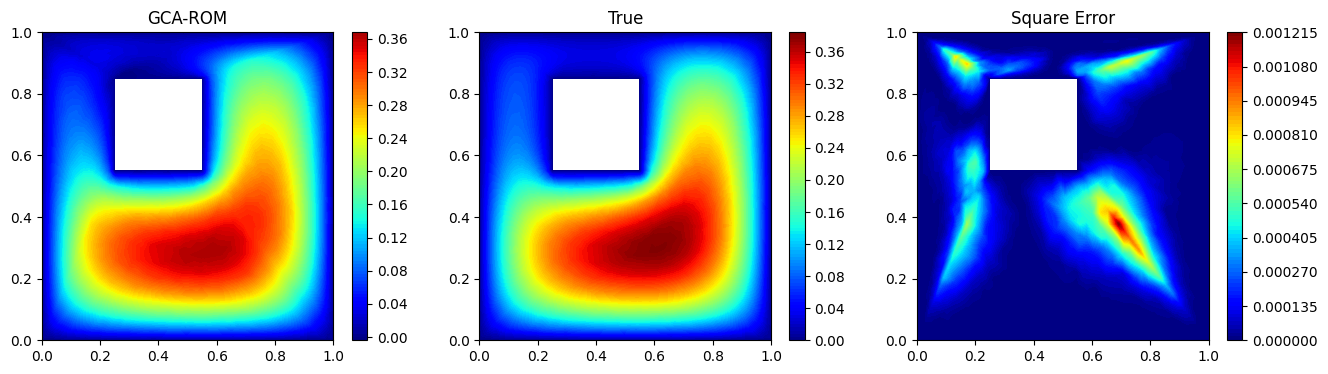

In [11]:
# compute error
l2_error = (torch.norm(out - u, dim=0) / torch.norm(u, dim=0)).mean()
print(f"L2 relative error {l2_error:.2%}")

# plot solution
idx_to_plot = 42
# Determine min and max values for color scaling
vmin = min(out[:, idx_to_plot].min(), u[:, idx_to_plot].min())
vmax = max(out[:, idx_to_plot].max(), u[:, idx_to_plot].max())
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.tricontourf(
    x[:, idx_to_plot],
    y[:, idx_to_plot],
    triang,
    out[:, idx_to_plot],
    100,
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
plt.title('GCA-ROM')
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title('True')
plt.tricontourf(
    x[:, idx_to_plot],
    y[:, idx_to_plot],
    triang,
    u[:, idx_to_plot],
    100,
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title('Square Error')
plt.tricontourf(x[:, idx_to_plot], y[:, idx_to_plot], triang, (u-out).pow(2)[:, idx_to_plot], 100, cmap='jet')
plt.colorbar()
plt.ticklabel_format()
plt.show()

Nice! We can see that the network is correctly learning the solution operator, and the workflow was very straightforward.  

You may notice that the network outputs are not as smooth as the actual solution. Don’t worry — training for longer (e.g., ~5000 epochs) will produce a smoother, more accurate reconstruction.

## What's Next?

Congratulations on completing the introductory tutorial on **Graph Convolutional Reduced Order Modeling**! Now that you have a solid foundation, here are a few directions to explore:

1. **Experiment with Training Duration** — Try different training durations and adjust the network architecture to optimize performance. Explore different integral kernels and observe how the results vary.

2. **Explore Physical Constraints** — Incorporate physics-informed terms or constraints during training to improve model generalization and ensure physically consistent predictions.

3. **...and many more!** — The possibilities are vast! Continue experimenting with advanced configurations, solvers, and features in PINA.

For more resources and tutorials, check out the [PINA Documentation](https://mathlab.github.io/PINA/).